### Я решил поменять датасет
___

### Библиотеки
___

In [2]:
import numpy as np
import pandas as pd
import holidays
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import tqdm

### Анализ и подготовка данных
___

In [3]:
data = pd.read_csv("retail_store_inventory.csv")
data.tail()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
73095,2024-01-01,S005,P0016,Furniture,East,96,8,127,18.46,73.73,20,Snowy,0,72.45,Winter
73096,2024-01-01,S005,P0017,Toys,North,313,51,101,48.43,82.57,10,Cloudy,0,83.78,Autumn
73097,2024-01-01,S005,P0018,Clothing,West,278,36,151,39.65,11.11,10,Rainy,0,10.91,Winter
73098,2024-01-01,S005,P0019,Toys,East,374,264,21,270.52,53.14,20,Rainy,0,55.80,Spring
73099,2024-01-01,S005,P0020,Groceries,East,117,6,165,2.33,78.39,20,Rainy,1,79.52,Spring


In [4]:
data.columns

Index(['Date', 'Store ID', 'Product ID', 'Category', 'Region',
       'Inventory Level', 'Units Sold', 'Units Ordered', 'Demand Forecast',
       'Price', 'Discount', 'Weather Condition', 'Holiday/Promotion',
       'Competitor Pricing', 'Seasonality'],
      dtype='object')

### Беру продажи в одном из регионов и убираю ненужные столбцы

In [5]:
data.Region.unique()

array(['North', 'South', 'West', 'East'], dtype=object)

In [6]:
(
    len(data[data["Region"] == "North"]),
    len(data[data["Region"] == "South"]),
    len(data[data["Region"] == "West"]),
    len(data[data["Region"] == "East"]),
)

(18228, 18297, 18226, 18349)

### Беру East, выбрасываю ненужные колонки и добавляю признак - выше ли цена чем у конкурента (bool)

In [7]:
data = data[data["Region"] == "East"]
data["Price_Higher_Than_Competitor"] = (
    data["Price"] > data["Competitor Pricing"]
).astype(int)
data = data.drop(
    columns=[
        "Store ID",
        "Region",
        "Inventory Level",
        "Units Ordered",
        "Demand Forecast",
        "Price",
        "Competitor Pricing",
        "Holiday/Promotion",
        "Seasonality",
    ]
)
data.sample(5)

,Date,Product ID,Category,Units Sold,Discount,Weather Condition,Price_Higher_Than_Competitor
32571,2022-11-22,P0012,Clothing,28,15,Rainy,1
68833,2023-11-20,P0014,Toys,158,0,Snowy,1
5178,2022-02-21,P0019,Toys,21,15,Cloudy,1
25786,2022-09-15,P0007,Electronics,45,0,Snowy,0
41183,2023-02-16,P0004,Furniture,103,10,Sunny,0


In [8]:
data["Date"] = pd.to_datetime(data["Date"])

In [9]:
country = "US"
# календарь праздников
country_holidays = holidays.US(years=2022)
data["Weekday"] = data["Date"].dt.weekday
data["Month"] = data["Date"].dt.month
data["Weekend"] = data["Date"].dt.dayofweek.isin([5, 6]).astype(int)
data["Holiday"] = data["Date"].isin(country_holidays).astype(int)

data["Tomorrow_Weekend_or_Holiday"] = (data["Date"] + pd.Timedelta(days=1)).apply(
    lambda x: int(x in country_holidays or x.dayofweek in [5, 6])
)


def holiday_within_7_days(date):
    for d in range(1, 8):
        check_date = date + timedelta(days=d)
        if check_date in country_holidays:
            return 1
    return 0


data["Holiday_Within_7_Days"] = data["Date"].apply(holiday_within_7_days)

/tmp/ipykernel_86977/324034834.py:7: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  data["Holiday"] = data["Date"].isin(country_holidays).astype(int)


In [10]:
data.sample(5)

,Date,Product ID,Category,Units Sold,Discount,Weather Condition,Price_Higher_Than_Competitor,Weekday,Month,Weekend,Holiday,Tomorrow_Weekend_or_Holiday,Holiday_Within_7_Days
66024,2023-10-23,P0005,Clothing,318,20,Rainy,1,0,10,0,0,0,0
15367,2022-06-03,P0008,Furniture,84,15,Snowy,1,4,6,0,0,1,0
31915,2022-11-16,P0016,Groceries,141,0,Cloudy,1,2,11,0,0,0,0
62018,2023-09-13,P0019,Groceries,291,10,Rainy,0,2,9,0,0,0,0
65143,2023-10-14,P0004,Toys,25,15,Sunny,0,5,10,1,0,1,0


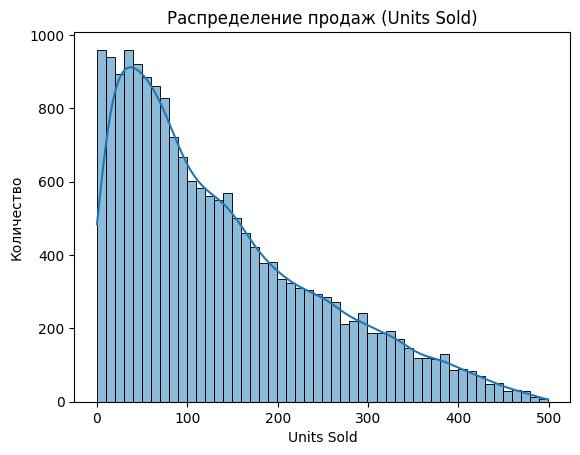

In [11]:
sns.histplot(data["Units Sold"], bins=50, kde=True)
plt.title("Распределение продаж (Units Sold)")
plt.xlabel("Units Sold")
plt.ylabel("Количество")
plt.show()

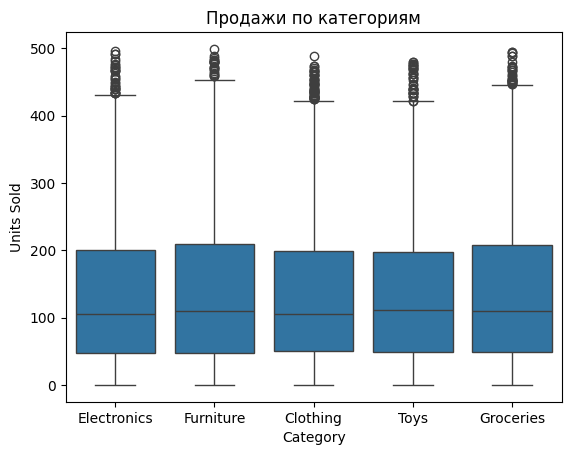

In [12]:
sns.boxplot(x="Category", y="Units Sold", data=data)
plt.title("Продажи по категориям")
plt.show()

/tmp/ipykernel_86977/1926896328.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Weekday", y="Units Sold", data=data, ci=None)


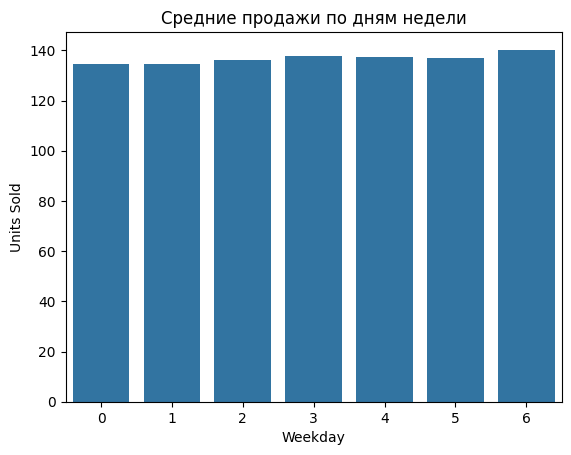

In [13]:
sns.barplot(x="Weekday", y="Units Sold", data=data, ci=None)
plt.title("Средние продажи по дням недели")
plt.show()

/tmp/ipykernel_86977/3987473319.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Month", y="Units Sold", data=data, ci=None)


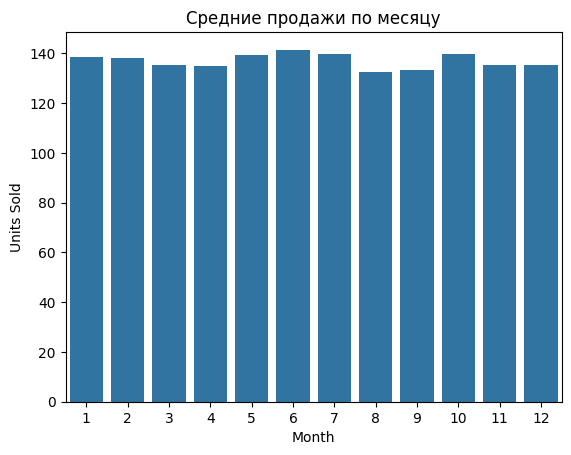

In [14]:
sns.barplot(x="Month", y="Units Sold", data=data, ci=None)
plt.title("Средние продажи по месяцу")
plt.show()

/tmp/ipykernel_86977/1662311033.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Weekend", y="Units Sold", data=data, ci=None)


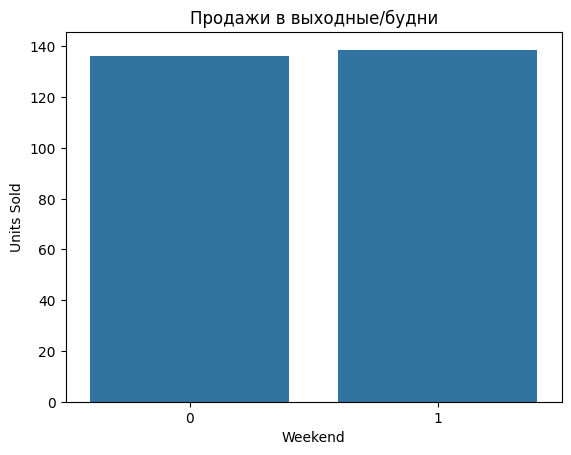

In [15]:
sns.barplot(x="Weekend", y="Units Sold", data=data, ci=None)
plt.title("Продажи в выходные/будни")
plt.show()

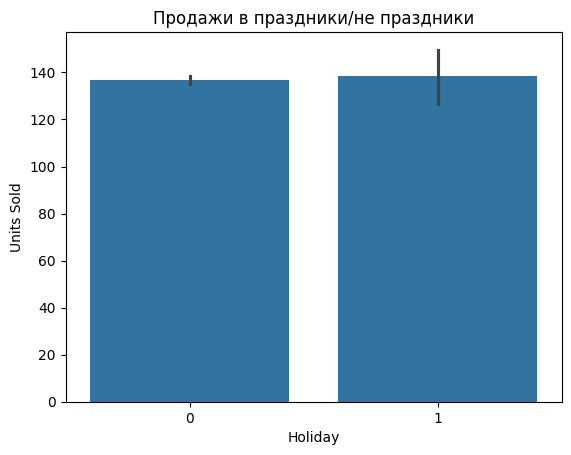

In [16]:
sns.barplot(x="Holiday", y="Units Sold", data=data)
plt.title("Продажи в праздники/не праздники")
plt.show()

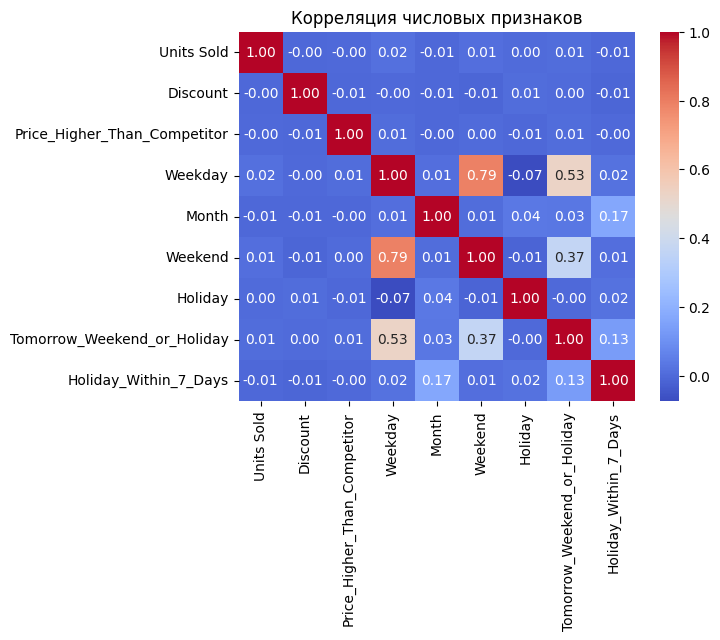

In [17]:
numeric_cols = data.select_dtypes(include="number").columns
corr = data[numeric_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Корреляция числовых признаков")
plt.show()

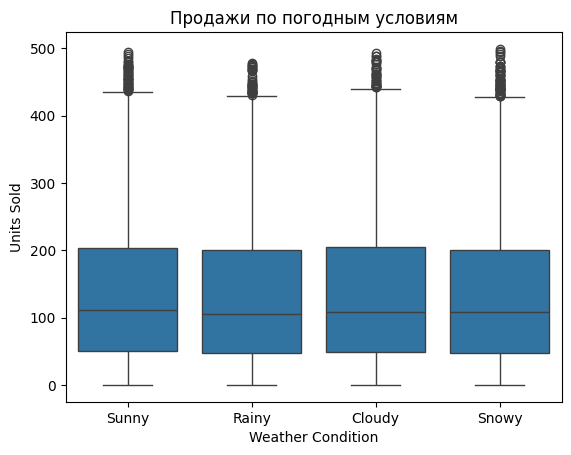

In [18]:
sns.boxplot(x="Weather Condition", y="Units Sold", data=data)
plt.title("Продажи по погодным условиям")
plt.show()

### Есть ощущение, что данные плохо нагенерены, но что поделать

### Фичи готовы, теперь энкодим, строим графики и смотрим на данные вообще

### сначала добавлю немного нанов в количество проданных единиц и заполню значения

In [19]:
n_missing = 100
missing_indices = np.random.choice(data.index, size=n_missing, replace=False)

data.loc[missing_indices, "Units Sold"] = np.nan

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18349 entries, 4 to 73099
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Date                          18349 non-null  datetime64[ns]
 1   Product ID                    18349 non-null  object        
 2   Category                      18349 non-null  object        
 3   Units Sold                    18249 non-null  float64       
 4   Discount                      18349 non-null  int64         
 5   Weather Condition             18349 non-null  object        
 6   Price_Higher_Than_Competitor  18349 non-null  int64         
 7   Weekday                       18349 non-null  int32         
 8   Month                         18349 non-null  int32         
 9   Weekend                       18349 non-null  int64         
 10  Holiday                       18349 non-null  int64         
 11  Tomorrow_Weekend_or_Holiday   183

In [21]:
group_cols = [
    "Product ID",
    "Price_Higher_Than_Competitor",
    "Weekend",
    "Holiday",
    "Tomorrow_Weekend_or_Holiday",
    "Holiday_Within_7_Days",
    "Month",
]

median_per_group = data.groupby(group_cols)["Units Sold"].median().dropna()
median_per_group

Product ID  Price_Higher_Than_Competitor  Weekend  Holiday  Tomorrow_Weekend_or_Holiday  Holiday_Within_7_Days  Month
P0001       0                             0        0        0                            0                      1        161.0
                                                                                                                2        156.5
                                                                                                                3        129.0
                                                                                                                4        158.0
                                                                                                                5        103.0
                                                                                                                         ...  
P0020       1                             1        0        1                            1                      10      

In [22]:
mask_nan = data["Units Sold"].isna()

for idx in data[mask_nan].index:
    key = tuple(data.loc[idx, group_cols])
    if key in median_per_group.index:
        data.at[idx, "Units Sold"] = median_per_group.loc[key]

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18349 entries, 4 to 73099
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Date                          18349 non-null  datetime64[ns]
 1   Product ID                    18349 non-null  object        
 2   Category                      18349 non-null  object        
 3   Units Sold                    18349 non-null  float64       
 4   Discount                      18349 non-null  int64         
 5   Weather Condition             18349 non-null  object        
 6   Price_Higher_Than_Competitor  18349 non-null  int64         
 7   Weekday                       18349 non-null  int32         
 8   Month                         18349 non-null  int32         
 9   Weekend                       18349 non-null  int64         
 10  Holiday                       18349 non-null  int64         
 11  Tomorrow_Weekend_or_Holiday   183

### осталось 6 nan, их просто удаляем

In [24]:
data = data.dropna(subset=["Units Sold"])

### Заполнили пропуски медианными значениями продаж таких же товаров с такими же значениями

In [25]:
data.sample(5)

,Date,Product ID,Category,Units Sold,Discount,Weather Condition,Price_Higher_Than_Competitor,Weekday,Month,Weekend,Holiday,Tomorrow_Weekend_or_Holiday,Holiday_Within_7_Days
4269,2022-02-12,P0010,Clothing,23.0,10,Sunny,1,5,2,1,0,1,0
44392,2023-03-20,P0013,Toys,67.0,10,Cloudy,1,0,3,0,0,0,0
35587,2022-12-22,P0008,Toys,30.0,0,Snowy,0,3,12,0,0,0,1
16339,2022-06-13,P0020,Clothing,179.0,5,Snowy,0,0,6,0,0,0,1
64770,2023-10-10,P0011,Toys,268.0,20,Cloudy,0,1,10,0,0,0,0


In [26]:
for i in data.columns:
    print(f"{i}: {len(data[i].unique())}")

Date: 731
Product ID: 20
Category: 5
Units Sold: 519
Discount: 5
Weather Condition: 4
Price_Higher_Than_Competitor: 2
Weekday: 7
Month: 12
Weekend: 2
Holiday: 2
Tomorrow_Weekend_or_Holiday: 2
Holiday_Within_7_Days: 2


### Нужно энкодить Product id, category и Weather
я люблю targetecnoder, но сначала делим на train test

In [27]:
data.columns

Index(['Date', 'Product ID', 'Category', 'Units Sold', 'Discount',
       'Weather Condition', 'Price_Higher_Than_Competitor', 'Weekday', 'Month',
       'Weekend', 'Holiday', 'Tomorrow_Weekend_or_Holiday',
       'Holiday_Within_7_Days'],
      dtype='object')

In [28]:
x = data[
    [
        "Product ID",
        "Category",
        "Discount",
        "Weather Condition",
        "Price_Higher_Than_Competitor",
        "Weekday",
        "Month",
        "Weekend",
        "Holiday",
        "Tomorrow_Weekend_or_Holiday",
        "Holiday_Within_7_Days",
    ]
]
y = data["Units Sold"]

In [29]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

In [30]:
cat_cols = ["Product ID", "Category", "Weather Condition"]

In [31]:
product_encoder = TargetEncoder()
x_train[["Product ID"]] = product_encoder.fit_transform(
    x_train[["Product ID"]], y_train
)
x_test[["Product ID"]] = product_encoder.transform(x_test[["Product ID"]])

In [32]:
category_encoder = TargetEncoder()
x_train[["Category"]] = category_encoder.fit_transform(x_train[["Category"]], y_train)
x_test[["Category"]] = category_encoder.transform(x_test[["Category"]])

In [33]:
weather_encoder = TargetEncoder()
x_train[["Weather Condition"]] = weather_encoder.fit_transform(
    x_train[["Weather Condition"]], y_train
)
x_test[["Weather Condition"]] = weather_encoder.transform(x_test[["Weather Condition"]])

In [34]:
numeric_cols = x_train.select_dtypes(include="number").columns

scaler = StandardScaler()

x_train[numeric_cols] = scaler.fit_transform(x_train[numeric_cols])

x_test[numeric_cols] = scaler.transform(x_test[numeric_cols])

In [35]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14679 entries, 66419 to 62964
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Product ID                    14679 non-null  float64
 1   Category                      14679 non-null  float64
 2   Discount                      14679 non-null  float64
 3   Weather Condition             14679 non-null  float64
 4   Price_Higher_Than_Competitor  14679 non-null  float64
 5   Weekday                       14679 non-null  float64
 6   Month                         14679 non-null  float64
 7   Weekend                       14679 non-null  float64
 8   Holiday                       14679 non-null  float64
 9   Tomorrow_Weekend_or_Holiday   14679 non-null  float64
 10  Holiday_Within_7_Days         14679 non-null  float64
dtypes: float64(11)
memory usage: 1.3 MB


In [36]:
x_train.sample(5)

,Product ID,Category,Discount,Weather Condition,Price_Higher_Than_Competitor,Weekday,Month,Weekend,Holiday,Tomorrow_Weekend_or_Holiday,Holiday_Within_7_Days
60582,-0.611800,1.224200,1.410645,-0.173992,-1.010616,-0.995292,0.418244,-0.633934,-0.136629,-0.675998,1.930289
13069,-0.183613,1.555958,0.705826,0.897637,-1.010616,-0.496644,-0.454119,-0.633934,-0.136629,-0.675998,-0.518057
11685,0.399672,-0.466093,0.705826,0.558638,-1.010616,-0.496644,-0.744907,-0.633934,-0.136629,-0.675998,-0.518057
54216,0.269296,1.221145,1.410645,0.755604,0.989496,-0.995292,-0.163332,-0.633934,-0.136629,-0.675998,1.930289
39693,0.666061,1.881440,1.410645,0.955864,0.989496,-0.496644,-1.326482,-0.633934,-0.136629,-0.675998,-0.518057


### Градиентный бустинг

In [37]:
cat_model = CatBoostRegressor(
    iterations=1000,
    depth=4,
    l2_leaf_reg=100,
    loss_function="RMSE",
    eval_metric="RMSE",
    verbose=100,
    random_state=42,
)

cat_model.fit(x_train, y_train, eval_set=(x_test, y_test), use_best_model=True)

y_pred = cat_model.predict(x_test)

rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

0:	learn: 109.3297724	test: 109.1713108	best: 109.1713108 (0)	total: 49.7ms	remaining: 49.6s
100:	learn: 109.0570359	test: 109.2004861	best: 109.1713108 (0)	total: 202ms	remaining: 1.8s
200:	learn: 108.8335183	test: 109.1993674	best: 109.1713108 (0)	total: 257ms	remaining: 1.02s
300:	learn: 108.6380802	test: 109.2154482	best: 109.1713108 (0)	total: 304ms	remaining: 706ms
400:	learn: 108.3861032	test: 109.2387130	best: 109.1713108 (0)	total: 352ms	remaining: 526ms
500:	learn: 108.1345423	test: 109.2659118	best: 109.1713108 (0)	total: 400ms	remaining: 398ms
600:	learn: 107.9193895	test: 109.2880736	best: 109.1713108 (0)	total: 448ms	remaining: 297ms
700:	learn: 107.7111666	test: 109.3261447	best: 109.1713108 (0)	total: 495ms	remaining: 211ms
800:	learn: 107.5112373	test: 109.3503820	best: 109.1713108 (0)	total: 541ms	remaining: 134ms
900:	learn: 107.3267064	test: 109.3952472	best: 109.1713108 (0)	total: 587ms	remaining: 64.5ms
999:	learn: 107.1482978	test: 109.4387264	best: 109.1713108 (

In [46]:
print("r2", r2, "rmse", rmse)

r2 -0.00015878883212772088 rmse 11918.375112362357


### Полносвязка

In [54]:
def train_model(
    model,
    train_loader,
    val_loader,
    dataset_sizes,
    criterion,
    optimizer,
    scheduler,
    num_epochs=25,
):
    best_model_wts = model.state_dict()
    best_rmse = float("inf")

    losses = {"train": [], "val": []}
    metrics = {"train": {"RMSE": [], "R2": []}, "val": {"RMSE": [], "R2": []}}

    for epoch in range(num_epochs):
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader

            running_loss = 0.0
            all_labels = []
            all_preds = []

            for inputs, labels in tqdm.tqdm(loader, leave=False, desc=f"{phase} iter:"):
                inputs, labels = inputs.to(device), labels.to(device)

                if phase == "train":
                    optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                all_labels.append(labels.detach().cpu().numpy())
                all_preds.append(outputs.detach().cpu().numpy())

            epoch_loss = running_loss / dataset_sizes[phase]
            y_true = np.vstack(all_labels)
            y_pred = np.vstack(all_preds)
            epoch_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            epoch_r2 = r2_score(y_true, y_pred)

            losses[phase].append(epoch_loss)
            metrics[phase]["RMSE"].append(epoch_rmse)
            metrics[phase]["R2"].append(epoch_r2)

            tqdm.tqdm.write(
                f"{phase} Epoch {epoch + 1}/{num_epochs} "
                f"Loss: {epoch_loss:.4f} RMSE: {epoch_rmse:.4f} R2: {epoch_r2:.4f}"
            )

            # сохраняем лучшую модель по RMSE на валидации
            if phase == "val" and epoch_rmse < best_rmse:
                best_rmse = epoch_rmse
                best_model_wts = model.state_dict()

        # шаг scheduler по RMSE на валидации
        scheduler.step(epoch_rmse)

    print(f"Best val RMSE: {best_rmse:.4f}")
    model.load_state_dict(best_model_wts)
    return model, (losses, metrics)


In [55]:
def plot_grafs(metrics):
    losses, metric_vals = metrics

    plt.figure(figsize=(16, 6))
    plt.plot(losses["train"], label="Train Loss")
    plt.plot(losses["val"], label="Validation Loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.figure(figsize=(16, 6))
    plt.plot(metric_vals["train"]["RMSE"], label="Train RMSE")
    plt.plot(metric_vals["val"]["RMSE"], label="Validation RMSE")
    plt.title("Training and Validation RMSE")
    plt.xlabel("Epochs")
    plt.ylabel("RMSE")
    plt.legend()
    plt.show()

    plt.figure(figsize=(16, 6))
    plt.plot(metric_vals["train"]["R2"], label="Train R2")
    plt.plot(metric_vals["val"]["R2"], label="Validation R2")
    plt.title("Training and Validation R2 Score")
    plt.xlabel("Epochs")
    plt.ylabel("R2")
    plt.legend()
    plt.show()


In [56]:
class Model(nn.Module):
    def __init__(self, input_dim, dropout=0.2):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)  # выходной слой для регрессии
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

In [57]:
X_train_tensor = torch.tensor(x_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(x_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

In [58]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [59]:
dataset_sizes = {"train": len(train_dataset), "val": len(test_dataset)}

In [60]:
model = Model(input_dim=X_train_tensor.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=5, verbose=True
)

In [61]:
model_trained, metrics = train_model(
    model,
    train_loader,
    val_loader,
    dataset_sizes,
    criterion,
    optimizer,
    scheduler,
    num_epochs=50,
)

train Epoch 1/50 Loss: 17197.4850 RMSE: 131.1392 R2: -0.4387


val Epoch 1/50 Loss: 12176.6650 RMSE: 110.3479 R2: -0.0218


train Epoch 2/50 Loss: 12580.3978 RMSE: 112.1624 R2: -0.0524


val Epoch 2/50 Loss: 12070.5716 RMSE: 109.8662 R2: -0.0129


train Epoch 3/50 Loss: 12481.3166 RMSE: 111.7198 R2: -0.0442


val Epoch 3/50 Loss: 12056.3315 RMSE: 109.8013 R2: -0.0117


train Epoch 4/50 Loss: 12447.3356 RMSE: 111.5676 R2: -0.0413


val Epoch 4/50 Loss: 12119.6006 RMSE: 110.0891 R2: -0.0170


train Epoch 5/50 Loss: 12435.5940 RMSE: 111.5150 R2: -0.0403


val Epoch 5/50 Loss: 12093.7560 RMSE: 109.9716 R2: -0.0149


train Epoch 6/50 Loss: 12380.5990 RMSE: 111.2681 R2: -0.0357


val Epoch 6/50 Loss: 11993.5185 RMSE: 109.5149 R2: -0.0065


train Epoch 7/50 Loss: 12337.1380 RMSE: 111.0727 R2: -0.0321


val Epoch 7/50 Loss: 11996.6103 RMSE: 109.5290 R2: -0.0067


train Epoch 8/50 Loss: 12409.7296 RMSE: 111.3990 R2: -0.0382


val Epoch 8/50 Loss: 12000.9894 RMSE: 109.5490 R2: -0.0071


train Epoch 9/50 Loss: 12345.7797 RMSE: 111.1116 R2: -0.0328


val Epoch 9/50 Loss: 12049.5181 RMSE: 109.7703 R2: -0.0112


train Epoch 10/50 Loss: 12316.5144 RMSE: 110.9798 R2: -0.0304


val Epoch 10/50 Loss: 11999.7748 RMSE: 109.5435 R2: -0.0070


train Epoch 11/50 Loss: 12380.9658 RMSE: 111.2698 R2: -0.0358


val Epoch 11/50 Loss: 12023.1300 RMSE: 109.6500 R2: -0.0089


train Epoch 12/50 Loss: 12326.0746 RMSE: 111.0229 R2: -0.0312


val Epoch 12/50 Loss: 11984.2527 RMSE: 109.4726 R2: -0.0057


train Epoch 13/50 Loss: 12295.0491 RMSE: 110.8830 R2: -0.0286


val Epoch 13/50 Loss: 12006.4132 RMSE: 109.5738 R2: -0.0075


train Epoch 14/50 Loss: 12309.8553 RMSE: 110.9498 R2: -0.0298


val Epoch 14/50 Loss: 11982.4336 RMSE: 109.4643 R2: -0.0055


train Epoch 15/50 Loss: 12317.6678 RMSE: 110.9850 R2: -0.0305


val Epoch 15/50 Loss: 11986.8808 RMSE: 109.4846 R2: -0.0059


train Epoch 16/50 Loss: 12313.3724 RMSE: 110.9656 R2: -0.0301


val Epoch 16/50 Loss: 11981.3509 RMSE: 109.4594 R2: -0.0054


train Epoch 17/50 Loss: 12331.7315 RMSE: 111.0483 R2: -0.0316


val Epoch 17/50 Loss: 12003.9878 RMSE: 109.5627 R2: -0.0073


train Epoch 18/50 Loss: 12325.5148 RMSE: 111.0203 R2: -0.0311


val Epoch 18/50 Loss: 11980.5783 RMSE: 109.4558 R2: -0.0054


train Epoch 19/50 Loss: 12286.4800 RMSE: 110.8444 R2: -0.0279


val Epoch 19/50 Loss: 11993.8693 RMSE: 109.5165 R2: -0.0065


train Epoch 20/50 Loss: 12348.2972 RMSE: 111.1229 R2: -0.0330


val Epoch 20/50 Loss: 12030.0944 RMSE: 109.6818 R2: -0.0095


train Epoch 21/50 Loss: 12324.3483 RMSE: 111.0151 R2: -0.0310


val Epoch 21/50 Loss: 12105.8629 RMSE: 110.0266 R2: -0.0159


train Epoch 22/50 Loss: 12263.1269 RMSE: 110.7390 R2: -0.0259


val Epoch 22/50 Loss: 11998.7922 RMSE: 109.5390 R2: -0.0069


train Epoch 23/50 Loss: 12352.6911 RMSE: 111.1427 R2: -0.0334


val Epoch 23/50 Loss: 12024.4751 RMSE: 109.6562 R2: -0.0091


train Epoch 24/50 Loss: 12261.8028 RMSE: 110.7330 R2: -0.0258


val Epoch 24/50 Loss: 12023.2516 RMSE: 109.6506 R2: -0.0090


train Epoch 25/50 Loss: 12290.3486 RMSE: 110.8618 R2: -0.0282


val Epoch 25/50 Loss: 11984.9090 RMSE: 109.4756 R2: -0.0057


train Epoch 26/50 Loss: 12256.3339 RMSE: 110.7083 R2: -0.0253


val Epoch 26/50 Loss: 11975.6681 RMSE: 109.4334 R2: -0.0050


train Epoch 27/50 Loss: 12259.4607 RMSE: 110.7225 R2: -0.0256


val Epoch 27/50 Loss: 12000.3528 RMSE: 109.5461 R2: -0.0070


train Epoch 28/50 Loss: 12268.6519 RMSE: 110.7639 R2: -0.0264


val Epoch 28/50 Loss: 11965.7582 RMSE: 109.3881 R2: -0.0041


train Epoch 29/50 Loss: 12355.3476 RMSE: 111.1546 R2: -0.0336


val Epoch 29/50 Loss: 12032.8686 RMSE: 109.6944 R2: -0.0098


train Epoch 30/50 Loss: 12263.7450 RMSE: 110.7418 R2: -0.0260


val Epoch 30/50 Loss: 11985.0534 RMSE: 109.4763 R2: -0.0058


train Epoch 31/50 Loss: 12314.5206 RMSE: 110.9708 R2: -0.0302


val Epoch 31/50 Loss: 11998.7195 RMSE: 109.5387 R2: -0.0069


train Epoch 32/50 Loss: 12319.7526 RMSE: 110.9944 R2: -0.0306


val Epoch 32/50 Loss: 12000.4683 RMSE: 109.5467 R2: -0.0070


train Epoch 33/50 Loss: 12239.9001 RMSE: 110.6341 R2: -0.0240


val Epoch 33/50 Loss: 12021.5028 RMSE: 109.6426 R2: -0.0088


train Epoch 34/50 Loss: 12310.4545 RMSE: 110.9525 R2: -0.0299


val Epoch 34/50 Loss: 12006.5425 RMSE: 109.5744 R2: -0.0076


train Epoch 35/50 Loss: 12271.6222 RMSE: 110.7774 R2: -0.0266


val Epoch 35/50 Loss: 12003.7858 RMSE: 109.5618 R2: -0.0073


train Epoch 36/50 Loss: 12272.4869 RMSE: 110.7813 R2: -0.0267


val Epoch 36/50 Loss: 11982.0355 RMSE: 109.4625 R2: -0.0055


train Epoch 37/50 Loss: 12266.0086 RMSE: 110.7520 R2: -0.0261


val Epoch 37/50 Loss: 12027.0341 RMSE: 109.6678 R2: -0.0093


train Epoch 38/50 Loss: 12195.8047 RMSE: 110.4346 R2: -0.0203


val Epoch 38/50 Loss: 12034.2124 RMSE: 109.7006 R2: -0.0099


train Epoch 39/50 Loss: 12223.0928 RMSE: 110.5581 R2: -0.0225


val Epoch 39/50 Loss: 11980.9113 RMSE: 109.4573 R2: -0.0054


train Epoch 40/50 Loss: 12274.9814 RMSE: 110.7925 R2: -0.0269


val Epoch 40/50 Loss: 11971.9692 RMSE: 109.4165 R2: -0.0047


train Epoch 41/50 Loss: 12277.3620 RMSE: 110.8033 R2: -0.0271


val Epoch 41/50 Loss: 12008.8223 RMSE: 109.5848 R2: -0.0077


train Epoch 42/50 Loss: 12199.7601 RMSE: 110.4525 R2: -0.0206


val Epoch 42/50 Loss: 12010.9314 RMSE: 109.5944 R2: -0.0079


train Epoch 43/50 Loss: 12239.6789 RMSE: 110.6331 R2: -0.0239


val Epoch 43/50 Loss: 11995.2610 RMSE: 109.5229 R2: -0.0066


train Epoch 44/50 Loss: 12261.4035 RMSE: 110.7312 R2: -0.0258


val Epoch 44/50 Loss: 11989.6873 RMSE: 109.4974 R2: -0.0061


train Epoch 45/50 Loss: 12277.9651 RMSE: 110.8060 R2: -0.0271


val Epoch 45/50 Loss: 12006.4663 RMSE: 109.5740 R2: -0.0076


train Epoch 46/50 Loss: 12257.2784 RMSE: 110.7126 R2: -0.0254


val Epoch 46/50 Loss: 11988.3038 RMSE: 109.4911 R2: -0.0060


train Epoch 47/50 Loss: 12207.7179 RMSE: 110.4885 R2: -0.0213


val Epoch 47/50 Loss: 11998.6849 RMSE: 109.5385 R2: -0.0069


train Epoch 48/50 Loss: 12256.0600 RMSE: 110.7071 R2: -0.0253


val Epoch 48/50 Loss: 11996.1674 RMSE: 109.5270 R2: -0.0067


train Epoch 49/50 Loss: 12229.1683 RMSE: 110.5856 R2: -0.0231


val Epoch 49/50 Loss: 11994.8944 RMSE: 109.5212 R2: -0.0066


train Epoch 50/50 Loss: 12211.3731 RMSE: 110.5051 R2: -0.0216


val Epoch 50/50 Loss: 12000.4253 RMSE: 109.5465 R2: -0.0070
Best val RMSE: 109.3881


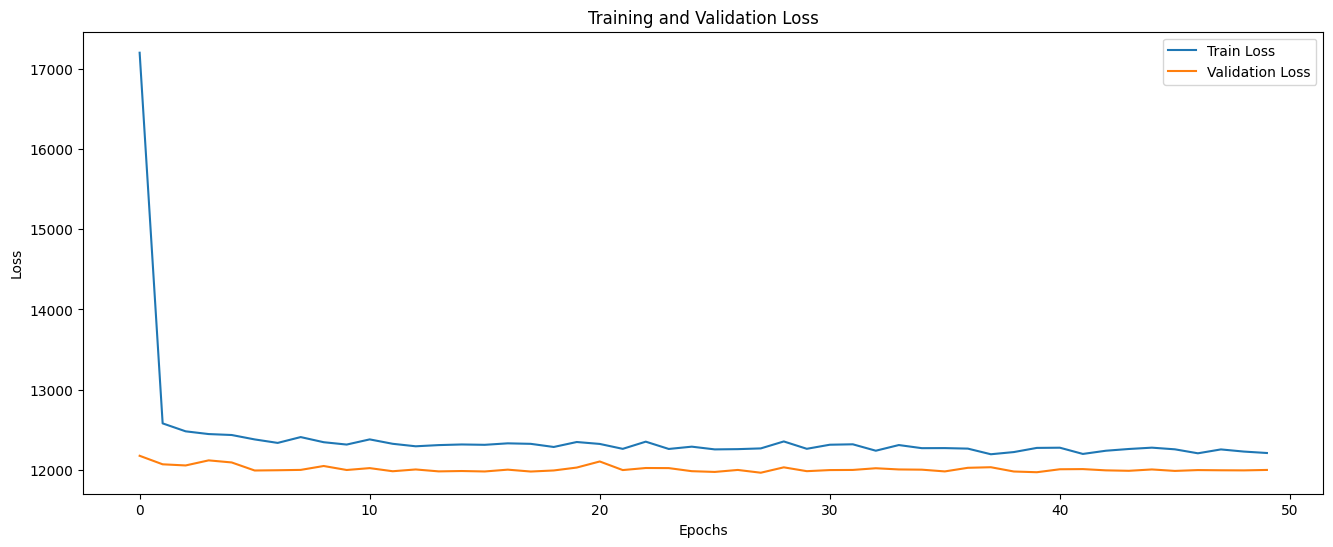

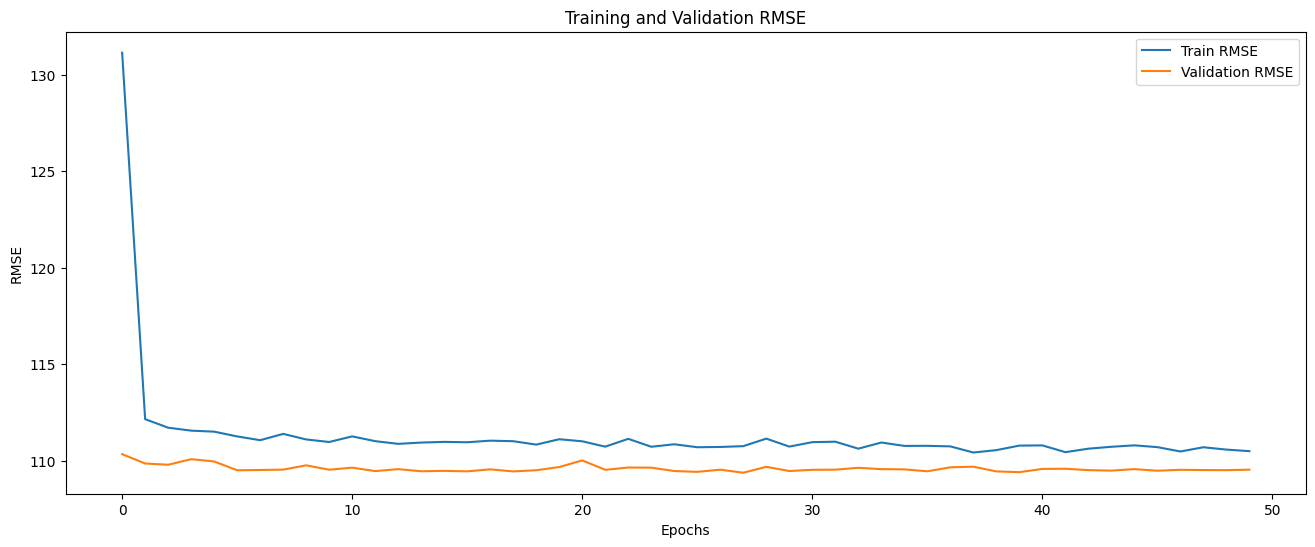

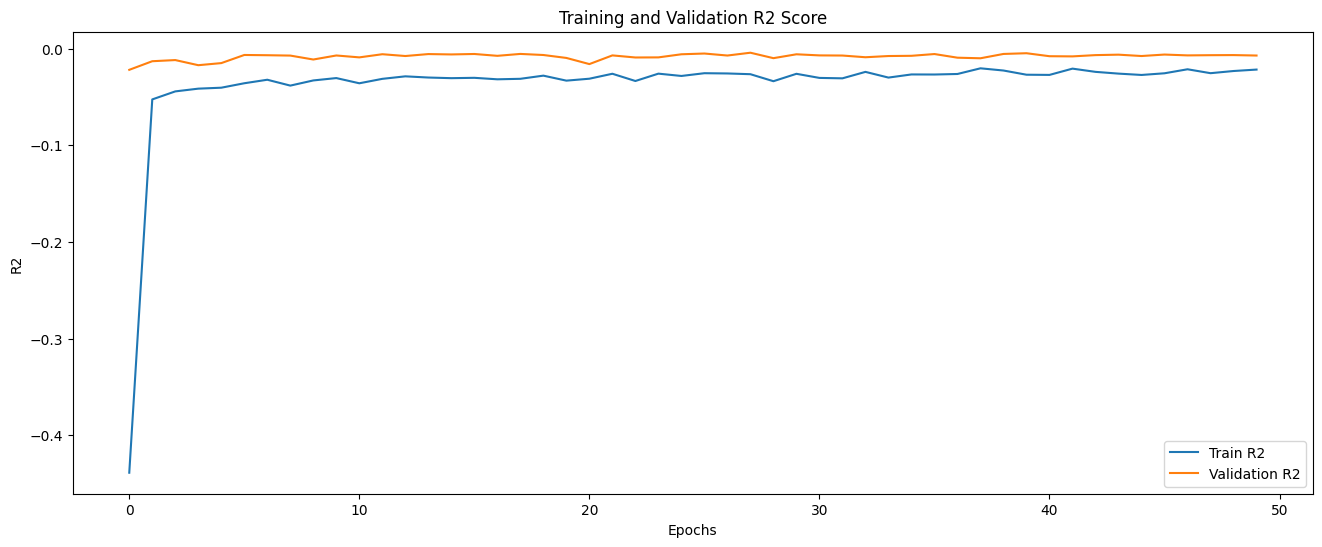

In [62]:
plot_grafs(metrics)